# Notebook 1:<br> **Dataset Exploration and Preprocessing**

## Problem Framing and Dataset Discovery

### 1. Problem Definition

As defined in the `Problem Definition` document:<br>

Predict whether a student in a given course will fall into Low / Medium / High risk of course outcome by end of course, using data recorded up to Week 12 (Day 96), so that course staff can prioritize early supportive interventions for learners most likely to need help.

Classification:<br>

1. **Low** risk for *Pass* or *Distinction*
2. **Medium** risk for *Fail*  
3. **High** risk for *Withdrawn*

For more details, please reference `/reports/01_problem_definition.md` in this repository and the `README.md` documents.

### 2. Setup

Initial setup for the notebook:

In [1]:
# Install requirements into the current kernel
import sys
import subprocess
print("Installing requirements from requirements.txt (this may take a minute)...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"])
print("Done. If imports still fail, restart the kernel (Kernel -> Restart).")

Installing requirements from requirements.txt (this may take a minute)...
Done. If imports still fail, restart the kernel (Kernel -> Restart).


Imports and display options: 

In [13]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import joblib

# scikit-learn imports
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42   # For reproducibility
CUTOFF_DAY = 98     # this is the cutoff day set to 14 weeks of the course (Day 98)

# Directories (relative to notebook location in notebooks)
RAW_DIR = Path("../inputs/raw")    # raw data directory
OUT_DIR = Path("../outputs")       # output directory  
FIG_DIR = OUT_DIR / "figures"       # figure output directory
TAB_DIR = OUT_DIR / "tables"        # table output directory
DATA_DIR = OUT_DIR / "data"         # processed data output directory

# Ensure output directories exist
for d in [OUT_DIR, FIG_DIR, TAB_DIR, DATA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Set pandas display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

### 3. Identify Dataset and Integrity

Verify the raw dataset's completeness and integrity before processing:

1. Ensure all required CSV files are present in the `raw` directory.
2. Compute MD5 checksums to detect data corruption or unauthorized changes.
3. Save a file inventory with sizes and hashes to `raw_file_inventory_md5.csv` for version control and reproducibility.

In [14]:
# Verify expected raw files exist
EXPECTED_FILES = [
    "courses.csv",
    "assessments.csv",
    "vle.csv",
    "studentInfo.csv",
    "studentRegistration.csv",
    "studentAssessment.csv",
    "studentVle.csv",
]

# Function to compute MD5 checksum of a file
def md5_file(path: Path, chunk_size: int = 2**20) -> str:
    h = hashlib.md5()
    with path.open("rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

missing = [f for f in EXPECTED_FILES if not (RAW_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        f"Missing expected CSV(s) in {RAW_DIR}:\n- " + "\n- ".join(missing)
    )

# Create inventory of raw files with sizes and MD5 checksums (in /tables/)
inventory = []
for f in EXPECTED_FILES:
    p = RAW_DIR / f
    inventory.append({
        "file": f,
        "bytes": p.stat().st_size,
        "md5": md5_file(p)
    })

inv_df = pd.DataFrame(inventory).sort_values("file")
inv_df.to_csv(TAB_DIR / "raw_file_inventory_md5.csv", index=False)
inv_df

,file,bytes,md5
1,assessments.csv,8200,6126f9d435767bcc70134b46f21c2a90
0,courses.csv,526,4c3df8a42a98a0d26b22f507007c31a8
5,studentAssessment.csv,5690310,9ceb38acaeb26fbc15c98b563290c1db
3,studentInfo.csv,3461652,ead11d001fe8b7aed1469daa643a812c
4,studentRegistration.csv,1109984,ef06e3d5784dc7dffe06ef911c5b190c
6,studentVle.csv,453836331,b8aae6f4ffd1523319aeb56d66b17f72
2,vle.csv,260126,0e7ef38c483daca42900ca426b66f8da


### 4. Dataset Contents and Tables

Reviewing the different tables used:

In [15]:
# Define the different tables used and create a dataframe for each
courses = pd.read_csv(RAW_DIR / "courses.csv")
assessments = pd.read_csv(RAW_DIR / "assessments.csv")
vle = pd.read_csv(RAW_DIR / "vle.csv")
studentInfo = pd.read_csv(RAW_DIR / "studentInfo.csv")
studentReg = pd.read_csv(RAW_DIR / "studentRegistration.csv")
studentAssess = pd.read_csv(RAW_DIR / "studentAssessment.csv")
studentVle = pd.read_csv(RAW_DIR / "studentVle.csv")

# Print the shape of each table
print("Shapes of loaded data tables:")
print("courses:", courses.shape)
print("assessments:", assessments.shape)
print("vle:", vle.shape)
print("studentInfo:", studentInfo.shape)
print("studentRegistration:", studentReg.shape)
print("studentAssessment:", studentAssess.shape)
print("studentVle:", studentVle.shape)

Shapes of loaded data tables:
courses: (22, 3)
assessments: (206, 6)
vle: (6364, 6)
studentInfo: (32593, 12)
studentRegistration: (32593, 5)
studentAssessment: (173912, 5)
studentVle: (10655280, 6)


Review the structure of critical tables (the features):

In [11]:
print("\nSample data from the Courses table:")
courses.head(25)


Sample data from the Courses table:


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


In [6]:
print("\nSample data from the Student Information table:")
studentInfo.head()


Sample data from the Student Information table:


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [7]:
print("\nSample data from the VLE table:")
vle.head()


Sample data from the VLE table:


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### 5. Data Dictionary

Supplementing the main file of the DATA_DICTIONARY.md by creating a data dictionary snapshot based on the structure of all loaded DataFrames:

In [8]:
# Capture metadata and sample values for a specific DataFrame
def data_dictionary_snapshot(df: pd.DataFrame, name: str, n_examples: int = 3) -> pd.DataFrame:
    rows = []
    for c in df.columns:
        examples = df[c].dropna().astype(str).head(n_examples).tolist()
        rows.append({
            "table": name,
            "column": c,
            "dtype": str(df[c].dtype),
            "missing_pct": float(df[c].isna().mean() * 100), # percentage of missing values
            "examples": " | ".join(examples)
        })
    return pd.DataFrame(rows)

# Combine snapshots of all tables into a single master dictionary
dd = pd.concat([
    data_dictionary_snapshot(courses, "courses"),
    data_dictionary_snapshot(assessments, "assessments"),
    data_dictionary_snapshot(vle, "vle"),
    data_dictionary_snapshot(studentInfo, "studentInfo"),
    data_dictionary_snapshot(studentReg, "studentRegistration"),
    data_dictionary_snapshot(studentAssess, "studentAssessment"),
    data_dictionary_snapshot(studentVle, "studentVle"),
], ignore_index=True)

# Export for documentation and display the first 100 (upper limit, there's less rows) rows in the head of the table
dd.to_csv(TAB_DIR / "data_dictionary_snapshot.csv", index=False)
dd.head(100)


,table,column,dtype,missing_pct,examples
0,courses,code_module,object,0.000000,AAA | AAA | BBB
1,courses,code_presentation,object,0.000000,2013J | 2014J | 2013J
2,courses,module_presentation_length,int64,0.000000,268 | 269 | 268
3,assessments,code_module,object,0.000000,AAA | AAA | AAA
4,assessments,code_presentation,object,0.000000,2013J | 2013J | 2013J
5,assessments,id_assessment,int64,0.000000,1752 | 1753 | 1754
6,assessments,assessment_type,object,0.000000,TMA | TMA | TMA
7,assessments,date,float64,5.339806,19.0 | 54.0 | 117.0
8,assessments,weight,float64,0.000000,10.0 | 20.0 | 20.0
9,vle,id_site,int64,0.000000,546943 | 546712 | 546998


## Data Preparation

### 6. Timeline

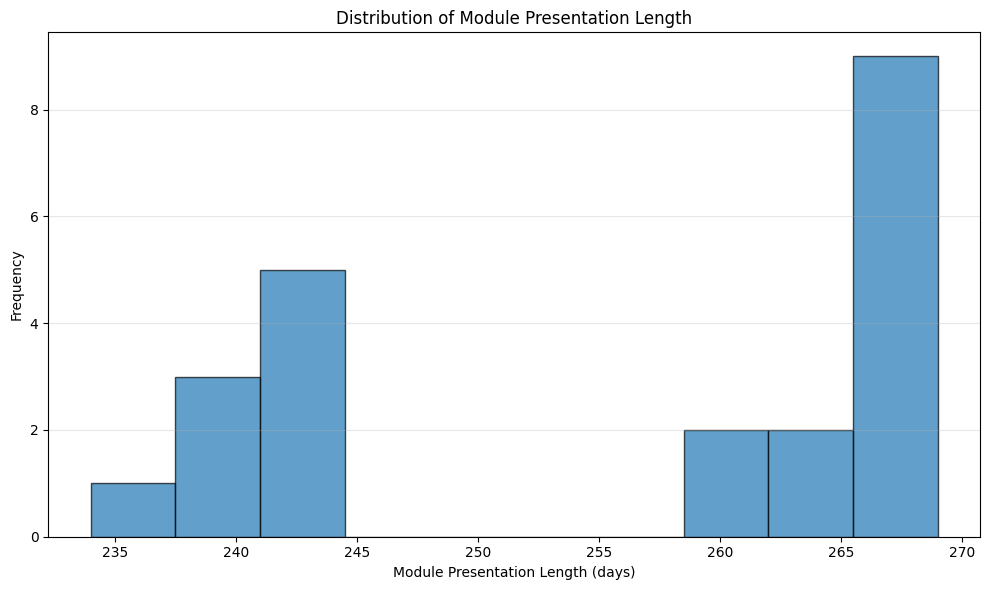

In [34]:
# Plot histogram of module_presentation_length
plt.figure(figsize=(10, 6))
plt.hist(courses['module_presentation_length'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Module Presentation Length (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Module Presentation Length')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_1_module_presentation_length_histogram.png", dpi=200)
plt.show()

In [20]:
# Alternative: Use pandas describe() for more comprehensive stats
print("\nDetailed statistics:")
print(courses['module_presentation_length'].describe())


Detailed statistics:
count     22.000000
mean     255.545455
std       13.654677
min      234.000000
25%      241.000000
50%      261.500000
75%      268.000000
max      269.000000
Name: module_presentation_length, dtype: float64


**Insight:**<br>
The duration of courses is over 200 days, the cutoff needs adjustment (8 weeks might be too short). Update selection of time to about half of the duration of a course (module-presentation combination) from the assumed 8 weeks to 14 weeks since all courses listed are over 234 days.

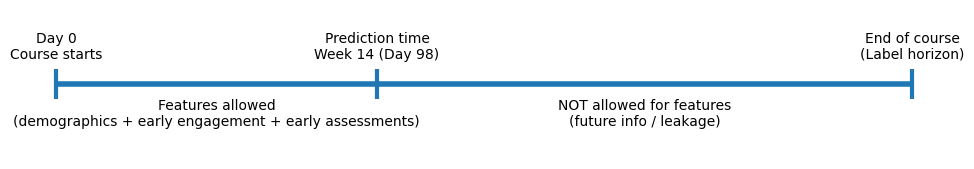

In [36]:
# Visualization: Timeline showing prediction time and feature leakage cutoff
fig, ax = plt.subplots(figsize=(10, 1.8))
ax.hlines(0, 0, courses['module_presentation_length'].median(), linewidth=4)
ax.vlines([0, CUTOFF_DAY, courses['module_presentation_length'].median()], -0.2, 0.2, linewidth=3)

ax.text(0, 0.35, "Day 0\nCourse starts", ha="center")
ax.text(CUTOFF_DAY, 0.35, f"Prediction time\nWeek 14 (Day {CUTOFF_DAY})", ha="center")
ax.text(courses['module_presentation_length'].median(), 0.35, "End of course\n(Label horizon)", ha="center")

ax.text(CUTOFF_DAY/2, -0.55, "Features allowed\n(demographics + early engagement + early assessments)", ha="center")
ax.text((CUTOFF_DAY+courses['module_presentation_length'].median())/2, -0.55, "NOT allowed for features\n(future info / leakage)", ha="center")

ax.set_ylim(-1, 1)
ax.set_xlim(-2, courses['module_presentation_length'].median()+2)
ax.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_2_timeline_prediction_time.png", dpi=200)
plt.show()


**Interpretation:**<br>
This timeline helps determine the cutoff date (as a number of days from the coures start day). All features must be computed using data available up to to the cutoff, while labels reflect end-of-course outcomes. 

Adjustment:<br>
The value of `CUTOFF_DAY` was updated to 98 (days) since all courses are longer than 200 days. This might need to be optimized again in a later stage.

This prevents “peeking into the future,” which would inflate performance and produce a model that cannot be used in a real early-warning setting.


## Defining Class Labels and Related Checks

### 7. Define Labels

Apply the mapping of a Risk (new engineered feature) to the Student Information dataframe based on the value of the `final_result` feature. 

In [39]:
# Create risk tiers based on final_result and add it to the Student Information table
studentInfo["final_result"] = studentInfo["final_result"].astype(str)

# Labels:
# 1. Low risk = Pass or Distinction
# 2. Medium risk = Fail
# 3. High risk = Withdrawn
label_map = {
    "Distinction": "Low Risk",
    "Pass": "Low Risk",
    "Fail": "Medium Risk",
    "Withdrawn": "High Risk",
}

# Map final_result to risk_tier
studentInfo["risk_tier"] = studentInfo["final_result"].map(label_map)
labeled = studentInfo.dropna(subset=["risk_tier"]).copy()

print("Show the rows affected:")
print("Kept rows:", labeled.shape[0], "of", studentInfo.shape[0])
labeled["risk_tier"].value_counts(dropna=False) # display the counts of each risk level


Show the rows affected:
Kept rows: 32593 of 32593


risk_tier
Low Risk       15385
High Risk      10156
Medium Risk     7052
Name: count, dtype: int64

### 8. Check for Imbalance

Visualizing the class labels to identify any imbalance:

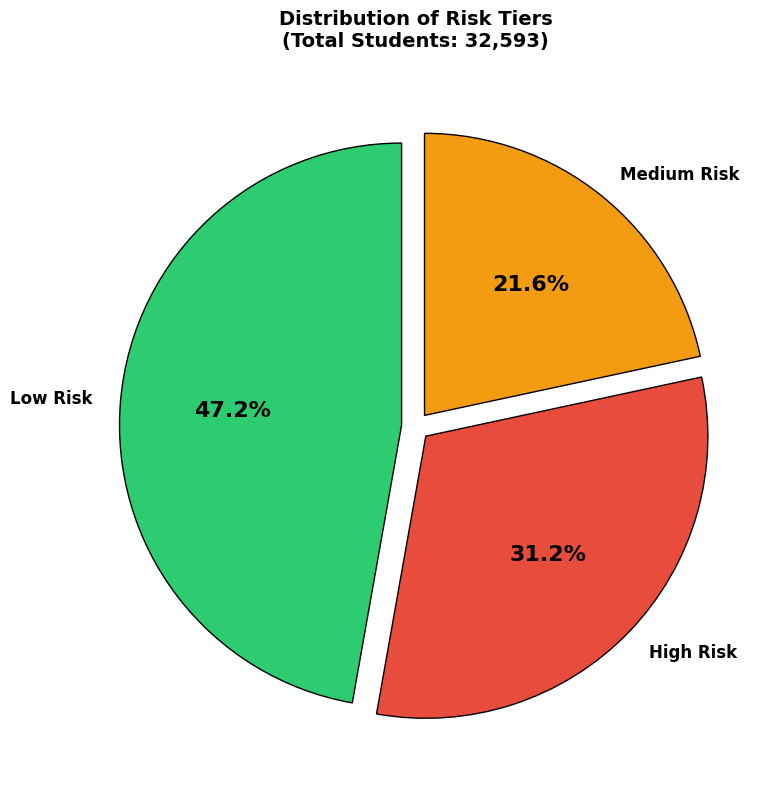


Risk Tier Distribution:
risk_tier
Low Risk       15385
High Risk      10156
Medium Risk     7052
Name: count, dtype: int64

Total labeled students: 32,593


In [57]:
# Create a pie chart for risk_tier distribution
risk_counts = labeled["risk_tier"].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#2ecc71', '#e74c3c', '#f39c12']  # Green for Low, Orange for Medium, Red for High
explode = (0.05, 0.05, 0.05)  # Slightly separate all slices

wedges, texts, autotexts = ax.pie(
    risk_counts.values,
    labels=risk_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=False,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# Enhance text formatting
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(16)
    autotext.set_weight('bold')

# Add title with total count
ax.set_title(f'Distribution of Risk Tiers\n(Total Students: {labeled.shape[0]:,})', 
             fontsize=14, weight='bold', pad=20)


plt.tight_layout()
plt.savefig(FIG_DIR / "visual_3_risk_tier_distribution.png", dpi=200, bbox_inches='tight')
plt.show()

print("\nRisk Tier Distribution:")
print(risk_counts)
print(f"\nTotal labeled students: {labeled.shape[0]:,}")

**Insight(s):**<br>
1. The chart if the dataset is imbalanced across the three risk tiers. As one class dominates, accuracy becomes unreliable. Because early-warning use cases typically care about correctly identifying High Risk (Withdrawn) and Medium Risk (Fail), the solution will prioritize macro-F1 as the primary evaluation metric for the models.
2. The assumption was the Withdrawn would be the smallest group, this is not the case.


### 9. Check for Timeline Issues (Events that Already Happened)

When considering what might happen before the cutoff date, there are two scenarios that stand out:

1. Students already withdrew from the course (for example, some programs have the option to leave the course withing the first few weeks with no penalty).
2. It is possible that within the cutoff period, a student's performance in assessments is unfixable, so they will fail the course regardless of future success. 

Only the first scenario will be handled since it's unlikely the that assessment structure makes the second scenario possible. 


In [55]:
base = labeled.merge(
    studentReg,
    on=["code_module", "code_presentation", "id_student"],
    how="left",
    validate="1:1"
)

for c in ["date_registration", "date_unregistration"]:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce")

pre_cutoff_withdraw = base["date_unregistration"].notna() & (base["date_unregistration"] <= CUTOFF_DAY)
print("Rows unregistered by prediction time:", int(pre_cutoff_withdraw.sum()))

base = base.loc[~pre_cutoff_withdraw].copy()
print("Base after exclusion:", base.shape)
base.head()


Rows unregistered by prediction time: 7240
Base after exclusion: (25353, 15)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,risk_tier,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,Low Risk,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,Low Risk,-53.0,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,Low Risk,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,Low Risk,-176.0,NaN
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,Low Risk,-110.0,NaN


Checking if the removal of the records changes the class distribution in a significant way:

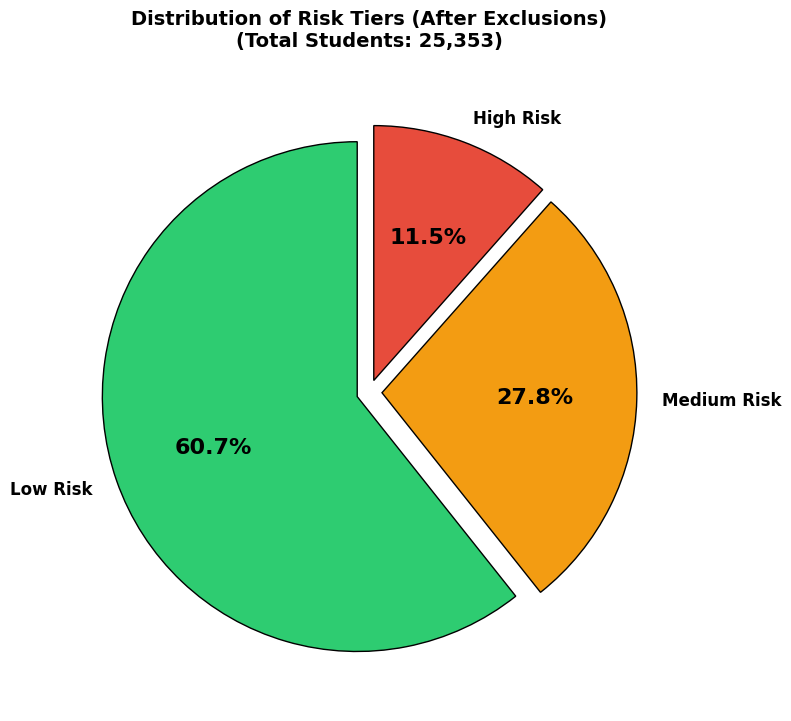


Risk Tier Distribution (After Exclusions):
risk_tier
Low Risk       15385
Medium Risk     7044
High Risk       2924
Name: count, dtype: int64

Total students after exclusion: 25,353
Students excluded (withdrew before cutoff): 7,240


In [59]:
# Create a pie chart for risk_tier distribution in base
risk_counts_base = base["risk_tier"].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green for Low, Orange for Medium, Red for High
explode = (0.05, 0.05, 0.05)  # Slightly separate all slices

wedges, texts, autotexts = ax.pie(
    risk_counts_base.values,
    labels=risk_counts_base.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=False,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# Enhance text formatting
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(16)
    autotext.set_weight('bold')

# Add title with total count
ax.set_title(f'Distribution of Risk Tiers (After Exclusions)\n(Total Students: {base.shape[0]:,})', 
             fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIG_DIR / "visual_4_risk_tier_distribution_after_exclusion.png", dpi=200, bbox_inches='tight')
plt.show()

print("\nRisk Tier Distribution (After Exclusions):")
print(risk_counts_base)
print(f"\nTotal students after exclusion: {base.shape[0]:,}")
print(f"Students excluded (withdrew before cutoff): {labeled.shape[0] - base.shape[0]:,}")